In [2]:
import UtilityFunctions as uf
import cv2
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import itertools as itr

In [3]:
#Led off validation step
def led_off_frame_validation(vidpath, led_off_frames):
    validated_led_off = []
    cap = cv2.VideoCapture(vidpath)
    breaker = 0
    i = 0
    while breaker == 0:
        if i == len(led_off_frames):
            breaker = 1
        if breaker == 1:
            break
        f = led_off_frames[i]
        cap.set(cv2.CAP_PROP_POS_FRAMES, f)
        ret, frame = cap.read()
        frame = cv2.putText(frame, f'frame number {str(f)}', (100, 100), 1, 5, (255, 255, 0), 3)
        cv2.imshow('validation', frame)
        key = ord('a')
        while key not in [ord('q'), ord('k'), ord('s'), ord('b'), ord('z'), ord('x')]:
            key = cv2.waitKey(0)
            if key == ord('q'):
                breaker = 1
                break
            elif key == ord('k'):
                if not f in validated_led_off:
                    validated_led_off.append(f)
                i += 1
                break
            elif key == ord('s'):
                if f in validated_led_off:
                    validated_led_off.remove(f)
                i+=1
                break
            elif key == ord('b'):
                i = i - 1
                break
            elif key == ord('z'):
                if i != 0:
                    if led_off_frames[i - 1] != led_off_frames[i] - 1:
                        led_off_frames[i] = led_off_frames[i] - 1
                break
            elif key == ord('x'):
                if i != len(led_off_frames)-1:
                    if led_off_frames[i + 1] != led_off_frames[i] + 1:
                        led_off_frames[i] = led_off_frames[i] + 1
                break

    cap.release()
    cv2.destroyAllWindows()
    return validated_led_off

In [4]:
def compress_frames(led_off_frames_ndarry):
    clustered_off_frames = []
    if type(led_off_frames_ndarry) == type(np.array([])):
        led_off_frames = led_off_frames_ndarry.tolist()
    else:
        led_off_frames = led_off_frames_ndarry
    if len(led_off_frames) == 0:
        print('no frames in the list')
        return []
    clust_count = 0
    start_clust = 0
    end_clust = 0
    for c in range(len(led_off_frames)-1):
        if clust_count == 0:
            start_clust = led_off_frames[c]
            end_clust = 0
        if led_off_frames[c] == led_off_frames[c+1] - 1:
            clust_count += 1
            continue
        else:
            end_clust = led_off_frames[c]

        if start_clust == end_clust:
            clustered_off_frames.append(start_clust)
        elif end_clust > start_clust:
            clustered_off_frames.append(start_clust)
            clustered_off_frames.append(end_clust)
        clust_count = 0
    if clust_count != 0:
        clustered_off_frames.append(start_clust)
        clustered_off_frames.append(led_off_frames[c])

    clustered_off_frames.append(led_off_frames[-1])
    return clustered_off_frames

In [5]:
def compress_frames_corrected(led_off_frames_ndarry,bite):
    clustered_off_frames = []
    if type(led_off_frames_ndarry) == type(np.array([])):
        led_off_frames = led_off_frames_ndarry.tolist()
    else:
        led_off_frames = led_off_frames_ndarry
    if len(led_off_frames) == 0:
        print('no frames in the list')
        return []
    clust_count = 0
    start_clust = 0
    end_clust = 0
    for c in range(len(led_off_frames)-1):
        if clust_count == 0:
            start_clust = led_off_frames[c]
            end_clust = 0
        if led_off_frames[c] == led_off_frames[c+1] - 1:
            clust_count += 1
            continue
        else:
            end_clust = led_off_frames[c]

        if start_clust == end_clust:
            clustered_off_frames.append(start_clust)
        elif end_clust > start_clust:
            clustered_off_frames.append(start_clust+bite)
            clustered_off_frames.append(end_clust-bite)
        clust_count = 0
    if clust_count != 0:
        clustered_off_frames.append(start_clust)
        clustered_off_frames.append(led_off_frames[c])

    clustered_off_frames.append(led_off_frames[-1])
    return clustered_off_frames

In [6]:
def find_suspected_frames(vidname,frame_val,z_scores):
    #First we find a threshold to use:
    print(f'Trying out threshold values for {vidname}:')
    plt.figure(figsize=[30,10])
    plt.plot(frame_val[0],z_scores)
    thr_values = [-2,-3,-4,-5]
    thr_count_pairs = []
    for threshold in range(len(thr_values)):
        suspects_bool = z_scores < thr_values[threshold]
        suspects = frame_val[0][suspects_bool]
        #print(f'for a threshold of {thr_values[threshold]} - there are {len(suspects)} suspected frames')
        thr_count_pairs.append([thr_values[threshold],len(suspects)])
    threshold_to_use = float(input(f'For a threshold of {thr_count_pairs[0][0]} there are {thr_count_pairs[0][1]} frames\n'
                                   f'For a threshold of {thr_count_pairs[1][0]} there are {thr_count_pairs[1][1]} frames\n'
                                   f'For a threshold of {thr_count_pairs[2][0]} there are {thr_count_pairs[2][1]} frames\n'
                                   f'For a threshold of {thr_count_pairs[3][0]} there are {thr_count_pairs[3][1]} frames\n'
                                   f'Enter threshold to use:'))
    sus_bool = z_scores < threshold_to_use
    plt.axhline(threshold_to_use, linewidth=3, color='r')
    plt.title(f'{vidname}, threshold= {threshold_to_use}', color='w',fontsize=40 )
    return frame_val[0][sus_bool] , threshold_to_use

In [7]:
#I need a buffed up suspect list - this is the function definition
def suspect_list_buffer(suspect_list,vidnames,frame_val_list,buff_amount):
    buffed_list = []
    for vid in range(len(vidnames)):
        buff = []
        for suspect in suspect_list[vid]:
            if int(suspect-buff_amount) > 0 & int(suspect+buff_amount)< len(frame_val_list[vid][0]):
                for i in itr.islice(frame_val_list[vid][0], int(suspect-buff_amount), int(suspect+buff_amount)):
                    if i not in buff:
                        buff.append(i)
        buffed_list.append(buff)
    buffed_array = np.array(buffed_list)
    return buffed_array

In [8]:
def extract_vidnames_from_paths(vid_paths):
    """
    :param vid_paths: a list of video paths for the current analysis
    :return: vidnames: the extracted name of the video for other functions
    """
    vidnames = []
    for vid in vid_paths:
        vidname = vid.split(sep="\\") ; vidname = vidname[len(vidname)-1]; vidname=vidname.split(sep='.') ; vidname=vidname[0]
        vidnames.append(vidname)
    print(vidnames)
    return vidnames

In [9]:
def produce_frame_val_list(vid_paths,threshold_value):
    """
    :param vid_paths: a list of str paths to videos for analysis
    :param threshold_value: the threshold to use in order to concentrate on LEDs
    :return: frame_val_list: a list of mean pixel values for each frame after threshold
    """
    frame_val_list = []
    for vid in vid_paths:
        print(f'working on video {vid}')
        frame_val = uf.arena_video_initial_thr(vid, 250)
        frame_val_list.append(frame_val)
    print(f'done, frame_val_list contains {len(frame_val_list)} objects',flush=True)

    return frame_val_list

In [10]:
def produce_z_mad_scores(frame_val_list):
    z_list = []
    mad_list = []
    for vid in frame_val_list:
        mad = stats.median_abs_deviation(vid[1])
        mad_scores = np.array(vid[1])
        mad_scores= np.sqrt((mad_scores - mad)**2)
        zscores = stats.zscore(vid[1])
        z_list.append(zscores)
        mad_list.append(mad_scores)
    return z_list, mad_list

In [11]:
#list videos for analysis and produce vidnames
vid_paths = [
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\back_20201230T183223.mp4',
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\left_20201230T183223.mp4',
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\realtime_20201230T183223.mp4',
    r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\right_20201230T183223.mp4'
            ]
vidnames = []
for vid in vid_paths:
    vidname = vid.split(sep="\\") ; vidname = vidname[len(vidname)-1]; vidname=vidname.split(sep='.') ; vidname=vidname[0]
    vidnames.append(vidname)
print(vidnames)

['back_20201230T183223', 'left_20201230T183223', 'realtime_20201230T183223', 'right_20201230T183223']


In [11]:
# This cell produces frame_val_list, which has the structure [frame index, mean pixel value after threshold]

frame_val_list = []
for vid in vid_paths:
    print(f'working on video {vid}')
    frame_val = uf.arena_video_initial_thr(vid, 250)
    frame_val_list.append(frame_val)
print(f'done, frame_val_list contains {len(frame_val_list)} objects',flush=True)

working on video D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\back_20201230T183223.mp4
working on video D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\left_20201230T183223.mp4
working on video D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\realtime_20201230T183223.mp4
working on video D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\right_20201230T183223.mp4
done, frame_val_list contains 4 objects


In [12]:
#produce Z and MAD values of the videos
z_list = []
mad_list = []
for vid in frame_val_list:
    mad = stats.median_abs_deviation(vid[1])
    mad_scores = np.array(vid[1])
    mad_scores= np.sqrt((mad_scores - mad)**2)
    zscores = stats.zscore(vid[1])
    z_list.append(zscores)
    mad_list.append(mad_scores)

In [71]:
"""
def find_suspected_frames_graphic(vidname,frame_val,z_scores):
    #First we find a threshold to use:
    print(f'Trying out threshold values for {vidname}:')
    plt.ion()
    plt.figure(figsize=[30,10])
    plt.plot(frame_val[0],z_scores)
    plt.title('click to choose threshold')
    plt.waitforbuttonpress()
    threshold_to_use = plt.ginput(1,-1)
    sus_bool = z_scores < threshold_to_use
    plt.axhline(threshold_to_use, linewidth=3, color='r')
    plt.title(f'{vidname}, threshold= {threshold_to_use}', color='w',fontsize=40 )
    return frame_val[0][sus_bool] , threshold_to_use
"""

Trying out threshold values for back_20201230T183223:
Trying out threshold values for left_20201230T183223:
Trying out threshold values for realtime_20201230T183223:
Trying out threshold values for right_20201230T183223:


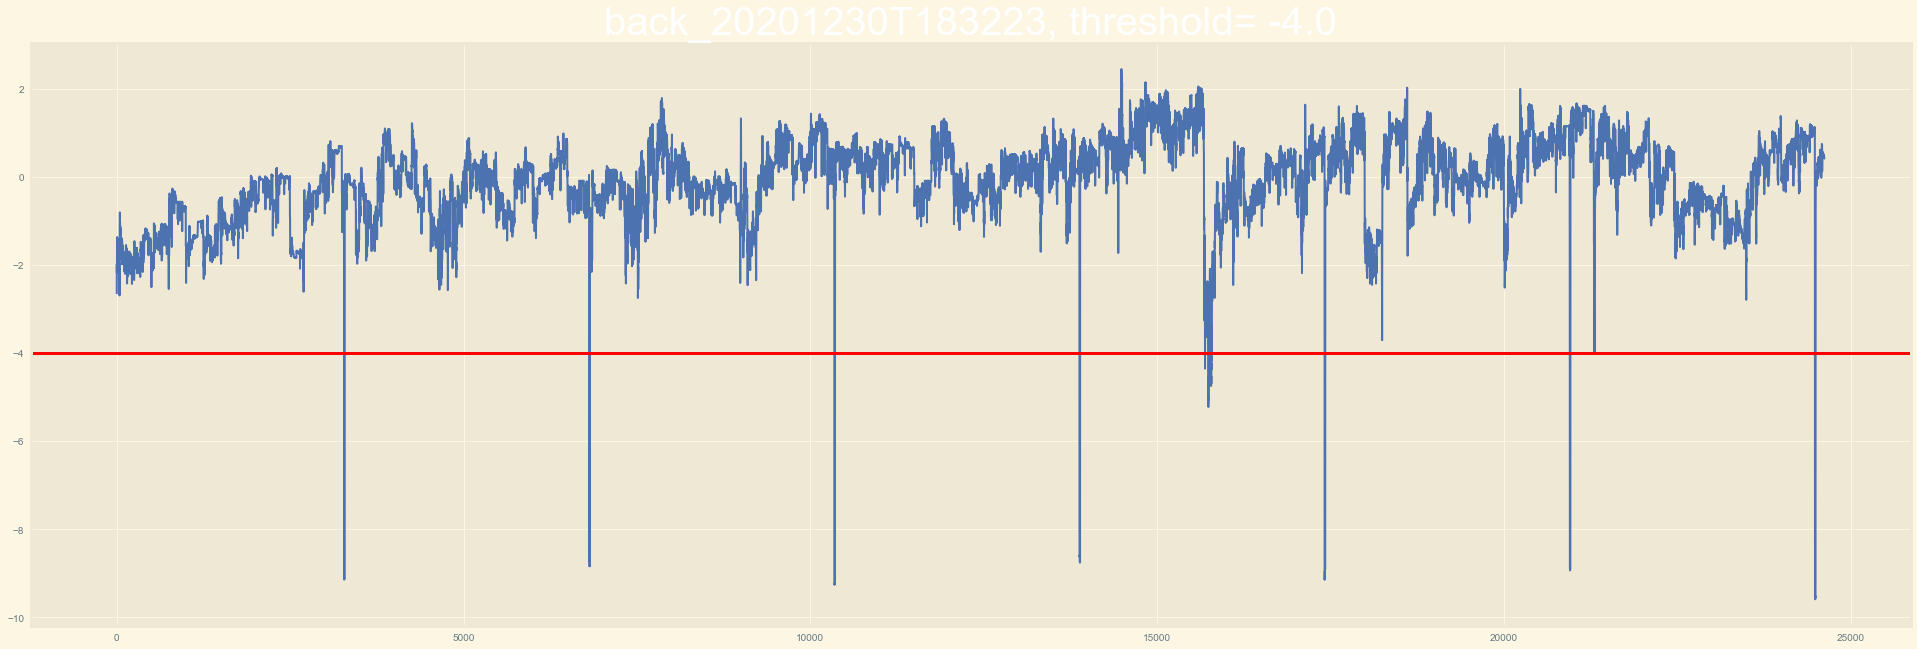

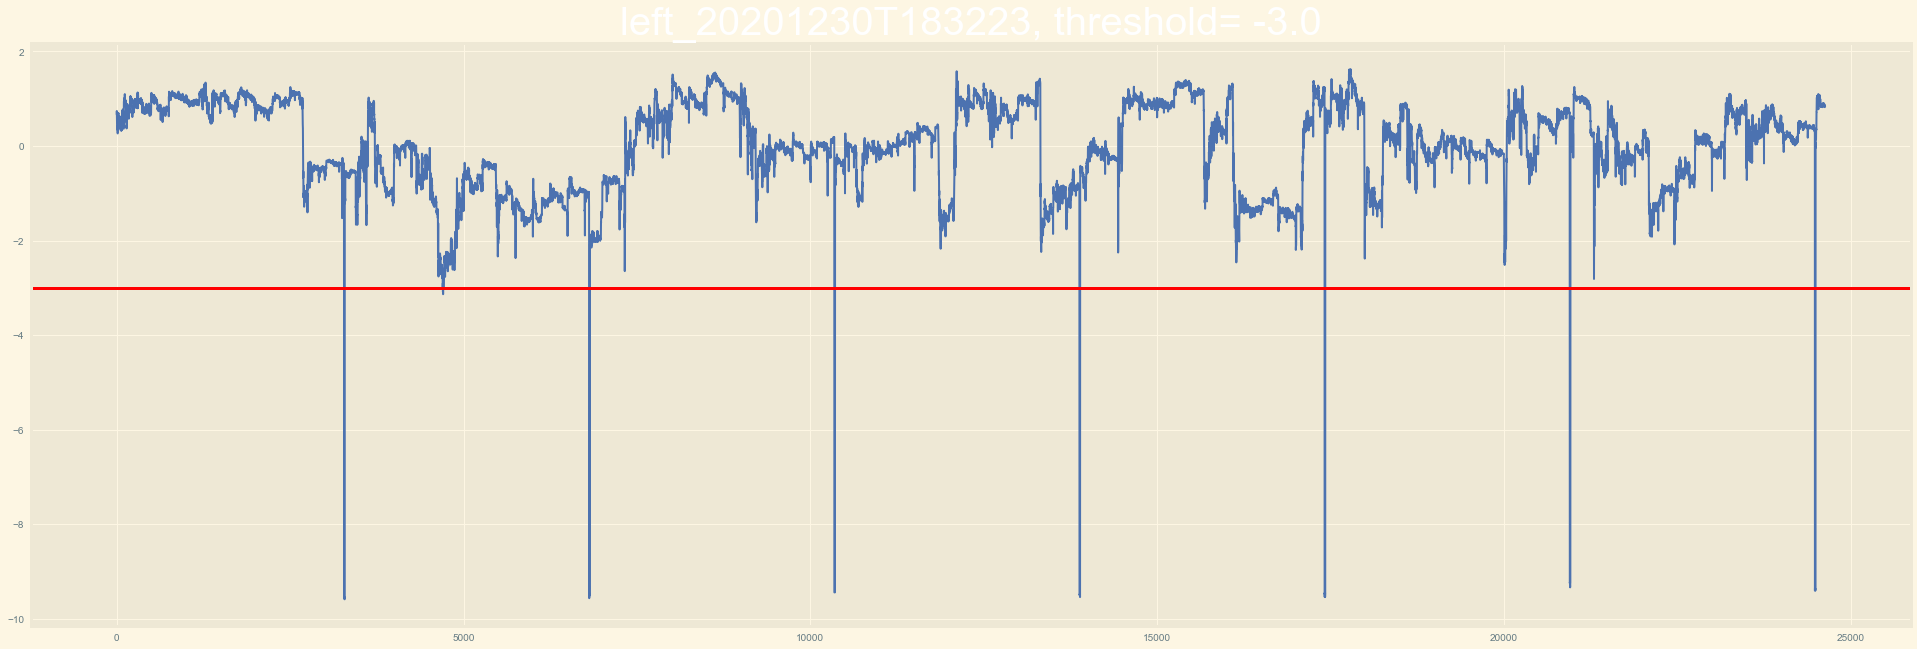

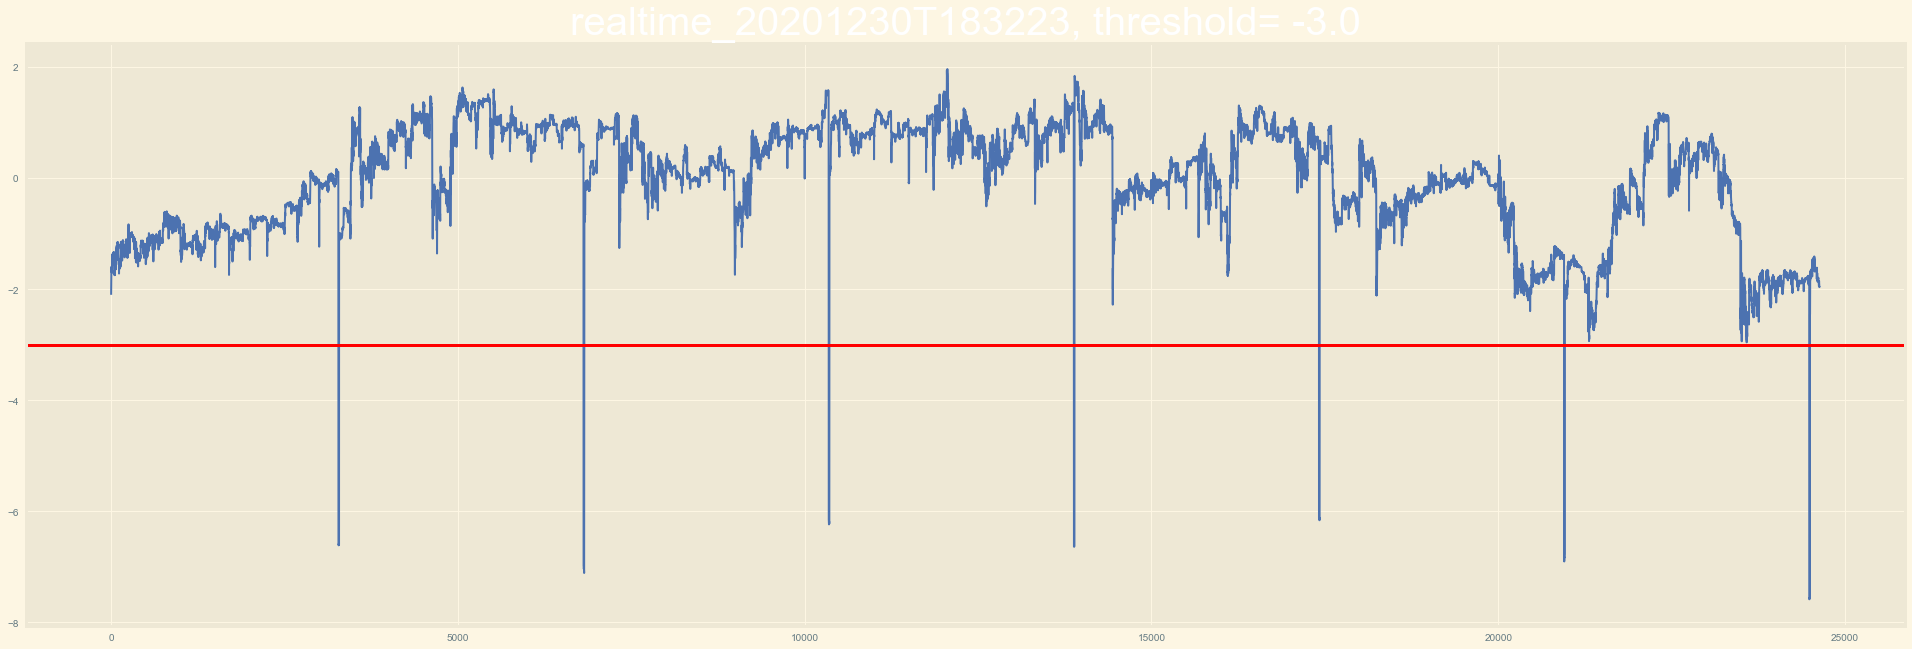

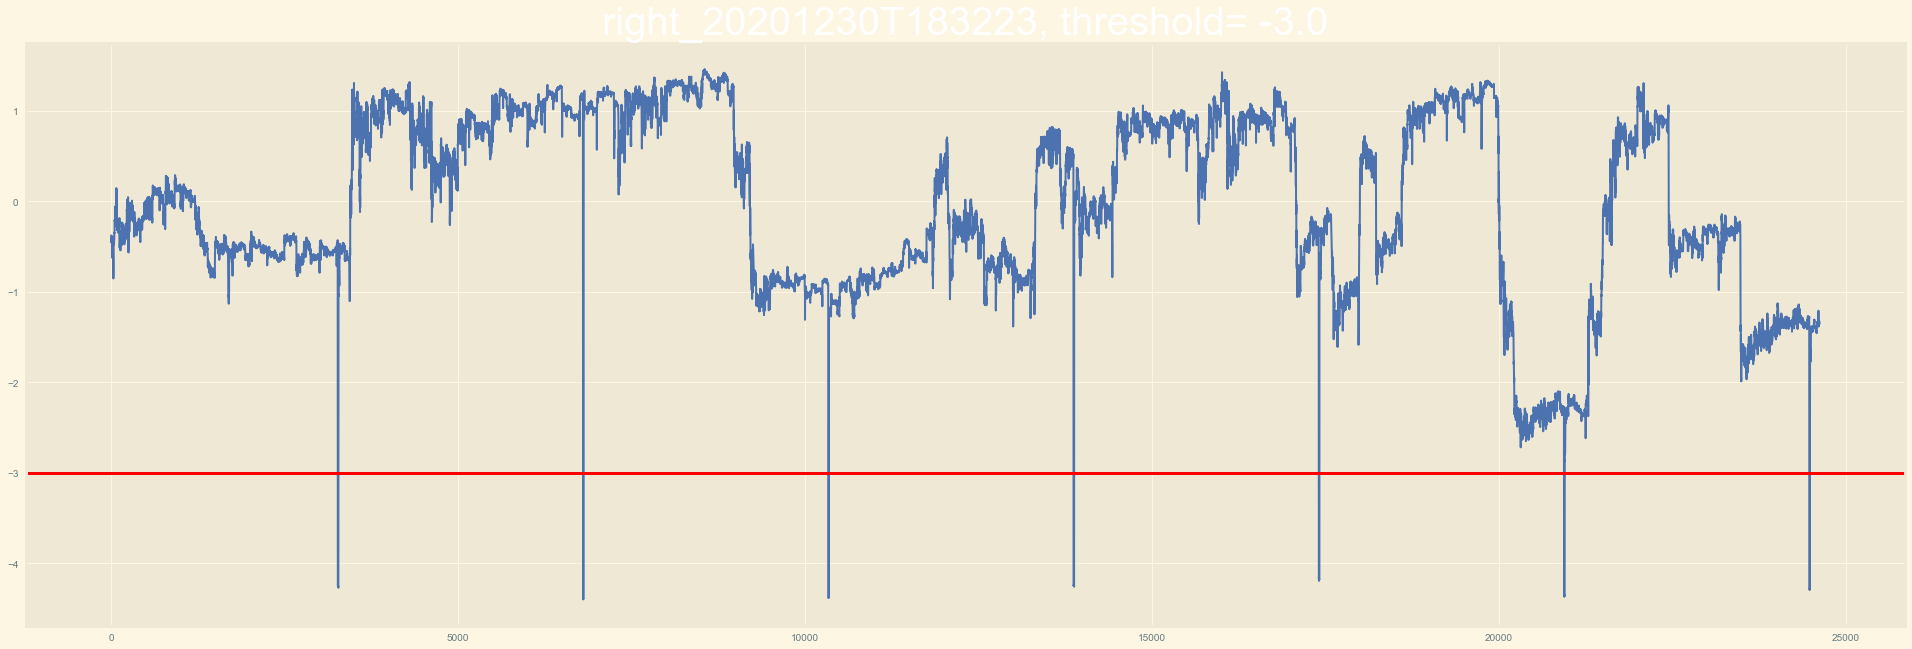

In [25]:
# Here we find suspected frames (Based on Z scores)

suspect_list = []
threshold_list = []
for vid in range(len(vidnames)):
    suspects , thr_for_list = find_suspected_frames(vidnames[vid],frame_val_list[vid],z_list[vid])
    suspect_list.append(suspects)
    threshold_list.append(thr_for_list)

In [11]:
change_threshold = input('to change a threshold enter y:')
if change_threshold == 'y':
    for vid in range(len(vidnames)):
        new_thr = float(input(f'{vidnames[vid]} \n'
                        f'Threshold = {threshold_list[vid]} \n'
                        f'suspected frames = {len(suspect_list[vid])}\n'
                        f'enter new threshold:' ))

    if new_thr != threshold_list[vid]:
        sus_bool = z_list[vid] < new_thr
        suspect_list[vid] = frame_val_list[vid][0][sus_bool]


In [26]:
buffed_array = suspect_list_buffer(suspect_list,vidnames,frame_val_list, 15)

<ipython-input-6-75361e17304d>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  buffed_array = np.array(buffed_list)


In [27]:
mutual = set(buffed_array[0])
for l in buffed_array[1:]:
    mutual = mutual & set(l)
sort_mutual = sorted(mutual)

print(f'There are {len(mutual)} mutual suspects')

There are 196 mutual suspects


In [28]:
clustered_mutual = compress_frames(list(sort_mutual))
corrected_clustered_mutual = compress_frames_corrected(list(sort_mutual),10)
print(len(clustered_mutual))
print(len(corrected_clustered_mutual))
print(clustered_mutual)

15
15
[3262.0, 3289.0, 6796.0, 6823.0, 10331.0, 10358.0, 13865.0, 13892.0, 17400.0, 17427.0, 20934.0, 20961.0, 24469.0, 24495.0, 24496.0]


In [29]:
validated_off_list = []
for vid in range(len(vidnames)):
    validated_off_list.append(led_off_frame_validation(vid_paths[vid],list(corrected_clustered_mutual)))

In [12]:
for vid in validated_off_list:
    print(vid)
handpicked_validated = validated_off_list[0]

NameError: name 'validated_off_list' is not defined

In [31]:
mutual_validated = set(validated_off_list[0])
for l in validated_off_list[1:-1]:
    mutual_validated = mutual_validated & set(l)
print(mutual_validated)
handpicked_validated = None

{13889.0, 6820.0, 24484.0, 17415.0, 10346.0, 24493.0, 17424.0, 10355.0, 3286.0, 20950.0, 13881.0, 6812.0, 20958.0}


In [2]:
for vid in range(len(vidnames)):
    plt.figure(figsize=[30,10])
    plt.ticklabel_format()
    plt.plot(frame_val_list[vid][0],frame_val_list[vid][1])
    for i in list(buffed_array[vid]):
        plt.axvline(i, linewidth=1, color='r', ymin=0.8)
    if handpicked_validated != None:
        for i in list(handpicked_validated):
            plt.axvline(i,linewidth=2,color='g',ymax=0.2)
    else:
        for i in list(mutual_validated):
            plt.axvline(i,linewidth=2,color='g',ymax=0.2)

NameError: name 'vidnames' is not defined

In [33]:
    if handpicked_validated != None:
        valid_off_frames = handpicked_validated
    else:
        valid_off_frames = sorted(list(mutual_validated))
    data_export = pd.DataFrame({'mutually validated arena frames' : valid_off_frames})
    data_export.to_csv(r'D:\AzulaTrials_30_12_2020\NimrodTrial1_30_12_3_20201230T182307\block2\trial1\videos\validated_off_frames.csv', mode='w')